<a href="https://www.kaggle.com/cameron858/spaceship-titanic-various-models-fe-80?scriptVersionId=89369354" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Load training data into pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

print(f'{train.head()}\n{train.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   


# Initial EDA # 

## Dealing with NaNs ##

In [2]:
# examine Nans
print(f'Training NaNs:\n{train.isnull().sum()}\n\nTesting NaNs:\n{test.isnull().sum()}')
print(f'\nThe data contains {train.isnull().sum().sum() + test.isnull().sum().sum()} NaNs')

Training NaNs:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Testing NaNs:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

The data contains 3441 NaNs


There are alot of NaNs in this dataset.

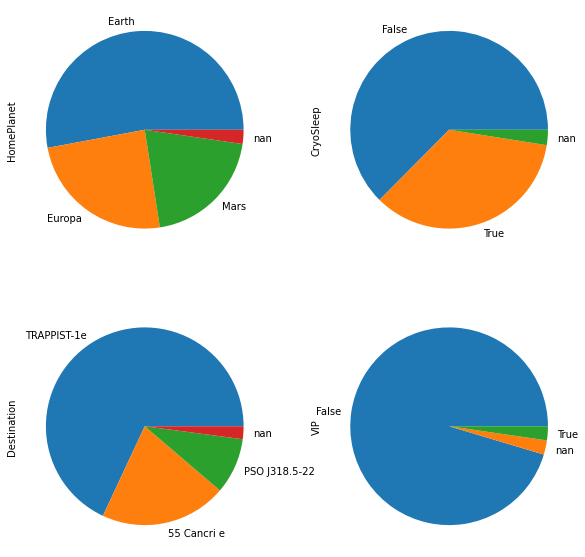

In [3]:
# class imbalance including NaNs

fig1, ax = plt.subplots(2, 2, figsize=(10, 10))
idx = 0

for row in [0, 1]:
    for col in [0, 1]:
        feat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'][idx]
        train[feat].value_counts(dropna=False).plot(kind='pie', ax = ax[row][col])
        idx += 1

The above features are highly imbalanced.

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RoomService'}>,
        <AxesSubplot:title={'center':'FoodCourt'}>],
       [<AxesSubplot:title={'center':'ShoppingMall'}>,
        <AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>]], dtype=object)

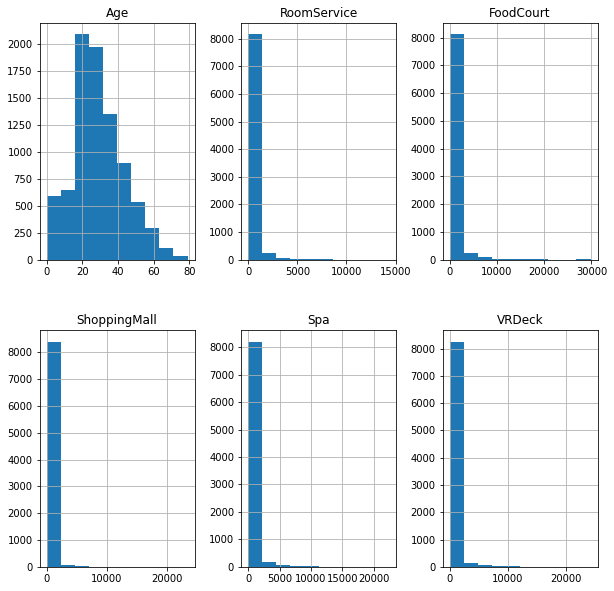

In [4]:
# distributions of numerical features
original_numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig2, ax = plt.subplots(2, 3, figsize=(10, 10))
train[original_numerical_features].hist(ax=ax)

The numerical features are very skewed (apart from Age)

We need to impute the missing values, the question is what method is best?
One way would be to impute with the most common value for each feature as such:
``` python
# extract columns with NaNs
contains_nans = train.columns[train.isnull().any()]

# fills with most common for all cols. Very basic.
for col in contains_nans:
    temp = train[col].value_counts().index[0]
    train[col] = train[col].fillna(temp)
    test[col] = test[col].fillna(temp)
```
However, we can attempt a slightly more foccused imputation for each feature.

In [5]:
# extract columns with NaNs
contains_nans = train.columns[train.isnull().any()]

# index removes transported to avod error when filling test data
for col in train.isnull().sum().index[0:-1]:
    # check if contains nans and is a float64
    if train[col].isnull().sum() > 0 and train[col].dtypes == 'float64':
        temp = train[col].median()
    else:
        # fill with most common value
        temp = train[col].value_counts().index[0]
        
    train[col] = train[col].fillna(temp)
    test[col] = test[col].fillna(temp)
    
print(f'Training NaNs:\n{train.isnull().sum()}\n\nTesting NaNs:\n{test.isnull().sum()}')
print(f'\nThe data contains {train.isnull().sum().sum() + test.isnull().sum().sum()} NaNs')

Training NaNs:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

Testing NaNs:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

The data contains 0 NaNs


Lets again plot the distributions for the features

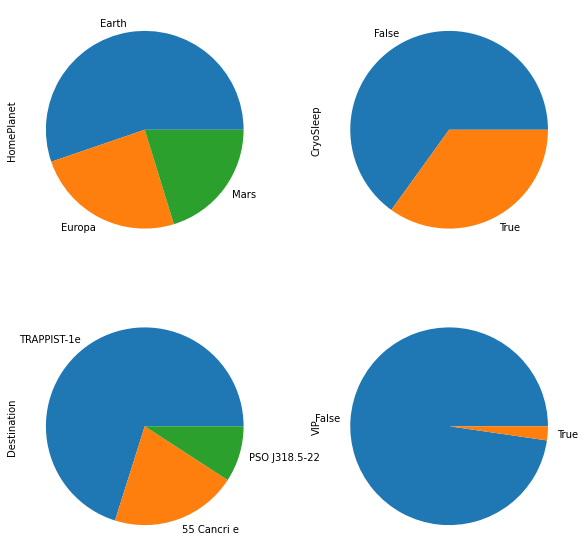

In [6]:
# class imbalance including NaNs

fig3, ax = plt.subplots(2, 2, figsize=(10, 10))
idx = 0

for row in [0, 1]:
    for col in [0, 1]:
        feat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'][idx]
        train[feat].value_counts(dropna=False).plot(kind='pie', ax = ax[row][col])
        idx += 1

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RoomService'}>,
        <AxesSubplot:title={'center':'FoodCourt'}>],
       [<AxesSubplot:title={'center':'ShoppingMall'}>,
        <AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>]], dtype=object)

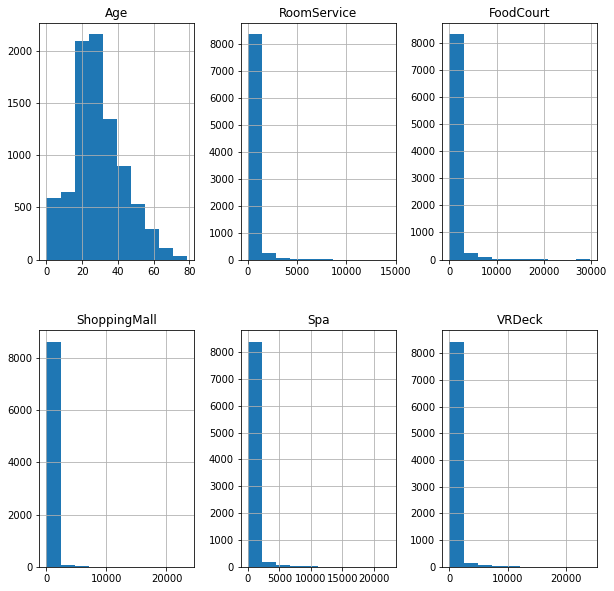

In [7]:
# distributions of numerical features
original_numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig4, ax = plt.subplots(2, 3, figsize=(10, 10))
train[original_numerical_features].hist(ax=ax)

<h1><center> Feature creation <center><h1>

Numerous features can be split into more features. The PassengerId has the format of 'XXXX_XX'. We can split the first 4 digits, and last 2 into seperate features. The cabin format is of "deck / number / side (port P or startboard S). We can seperate these into seperate columns. It is a valid assumption that families travel together, and stay in the same rooms. First and Last name features can be created from the original names feature. The 3 original features have been dropped afterwards.

In [8]:
# splitting PassengerId feature
train[['PassengerId_0', 'PassengerId_1']] = train['PassengerId'].str.split('_', 1, expand=True)
test[['PassengerId_0', 'PassengerId_1']] = test['PassengerId'].str.split('_', 1, expand=True)

# splitting Cabin feature
train[['Deck', 'Number', 'Side']] = train['Cabin'].str.split('/', 2, expand=True)
test[['Deck', 'Number', 'Side']] = test['Cabin'].str.split('/', 2, expand=True)

# splitting Name feature
train[['First name', 'Family name']] = train['Name'].str.split(' ', 1, expand=True)
test[['First name', 'Family name']] = test['Name'].str.split(' ', 1, expand=True)

# drop old features
train.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)
test.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

# snacks 
train['Food/drink'] = train['RoomService'] + train['FoodCourt']
test['Food/drink'] = test['RoomService'] + test['FoodCourt']

# Entertainment
train['Entertainment'] = train['Spa'] + train['VRDeck']
test['Entertainment'] = test['Spa'] + test['VRDeck']

# Total spent
train['TotalSpent'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
test['TotalSpent'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

# log transform of age
train['LogAge'] = (train['Age'] - train['Age'].min() + 1).transform(np.log)
test['LogAge'] = (test['Age'] - test['Age'].min() + 1).transform(np.log)

In [9]:
# baller: CryoSleep = False and TotalSpent > TotalSpent.median()

def is_baller(df):
    mask = (df['CryoSleep'] == False) & (df['TotalSpent'] > df['TotalSpent'].median())    
    return mask
    
train['Baller'] = is_baller(train)
test['Baller'] = is_baller(test)

In [10]:
# an attempt to make a 'Class' feature wil be done
# WIP

In [11]:
# Examining dangerous decks: more people died than not

danger_decks = []

# is danger deck?
for idx, deck in enumerate(train['Deck'].unique()):
    temp = train[train['Deck'] == deck]
    counts = temp['Transported'].value_counts().sort_index(ascending=False).values # list in form of [True count, False count]
    if counts[1] > counts[0]:
        print(f'{deck} is a dangerous deck. {counts[1]} people died compared to the {counts[0]} that survived')
        # easier to read than using a set
        if deck not in danger_decks:
            danger_decks.append(deck)

# new feature
train['DangerDeck'] = np.where(train['Deck'].isin(danger_decks), 1, 0)
test['DangerDeck'] = np.where(test['Deck'].isin(danger_decks), 1, 0)

F is a dangerous deck. 1565 people died compared to the 1229 that survived
A is a dangerous deck. 129 people died compared to the 127 that survived
E is a dangerous deck. 563 people died compared to the 313 that survived
D is a dangerous deck. 271 people died compared to the 207 that survived
T is a dangerous deck. 4 people died compared to the 1 that survived


Scale continuous features, and impute missing values. We will examine the difference between the MinMax and Standard scaler from the sklearn library.

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Extract continuous features
continuous_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Food/drink',
                   'Entertainment', 'TotalSpent', 'LogAge']

min_max_scaler = MinMaxScaler()
stand_scaler = StandardScaler()

train_min_max = train
train_standard = train

train_min_max[continuous_cols] = min_max_scaler.fit_transform(train_min_max[continuous_cols])
train_standard[continuous_cols] = stand_scaler.fit_transform(train_standard[continuous_cols])

In [13]:
train[continuous_cols] = min_max_scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = min_max_scaler.fit_transform(test[continuous_cols])

In [14]:
from sklearn.preprocessing import LabelEncoder

def encode_df_cols(df, columns):
    for col in columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype('str'))   
    return df

cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Number', 'Side', 'First name', 
            'Family name', 'PassengerId_0', 'PassengerId_1', 'DangerDeck', 'Baller']
train = encode_df_cols(train, cat_cols)
test = encode_df_cols(test, cat_cols)

print(f'Training:\n{train.head()}\nTesting:\n{test.head()}')

Training:
   HomePlanet  CryoSleep  Destination       Age  VIP  RoomService  FoodCourt  \
0           1          0            2  0.493671    0     0.000000   0.000000   
1           0          0            2  0.303797    0     0.007608   0.000302   
2           1          0            2  0.734177    1     0.003001   0.119948   
3           1          0            2  0.417722    0     0.000000   0.043035   
4           0          0            2  0.202532    0     0.021149   0.002348   

   ShoppingMall       Spa    VRDeck  ...  Number  Side  First name  \
0      0.000000  0.000000  0.000000  ...       0     0        1614   
1      0.001064  0.024500  0.001823  ...       0     1        1407   
2      0.000000  0.299670  0.002030  ...       0     1         156   
3      0.015793  0.148563  0.007997  ...       0     1        2276   
4      0.006428  0.025214  0.000083  ...       1     1        2642   

   Family name  Food/drink  Entertainment  TotalSpent    LogAge  Baller  \
0         143

In [15]:
# double check no NaNs exist
train.isnull().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
PassengerId_0    0
PassengerId_1    0
Deck             0
Number           0
Side             0
First name       0
Family name      0
Food/drink       0
Entertainment    0
TotalSpent       0
LogAge           0
Baller           0
DangerDeck       0
dtype: int64

# Feature Selections #

This sections aims to evaluate each feature in relation to the target ('Transported'). This should assist our models decisions. The numerical and categorical features will be evaluated seperately.

<h2> Numerical Features <h2>

In [16]:
# list numerical features from previous section
continuous_cols

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Food/drink',
 'Entertainment',
 'TotalSpent',
 'LogAge']

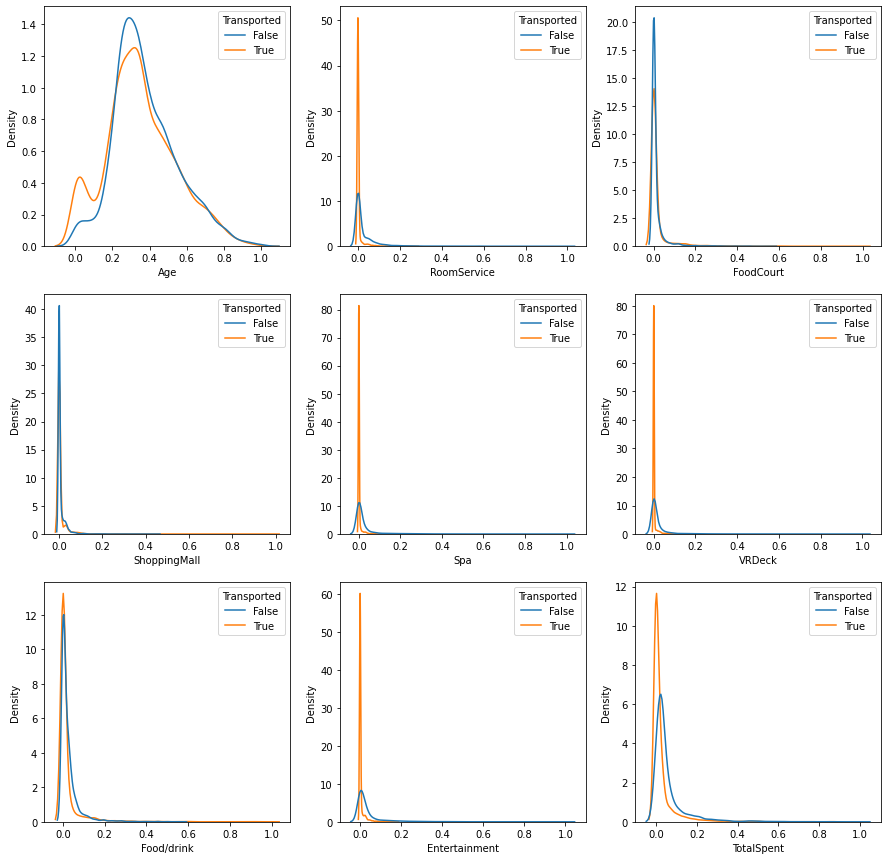

In [17]:
import seaborn as sns

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
idx = 0

for row in range(0,3):
    for col in range(0,3):
        sns.kdeplot(data=train, x=continuous_cols[idx], hue="Transported", ax=ax[row][col])
        idx+=1

<AxesSubplot:>

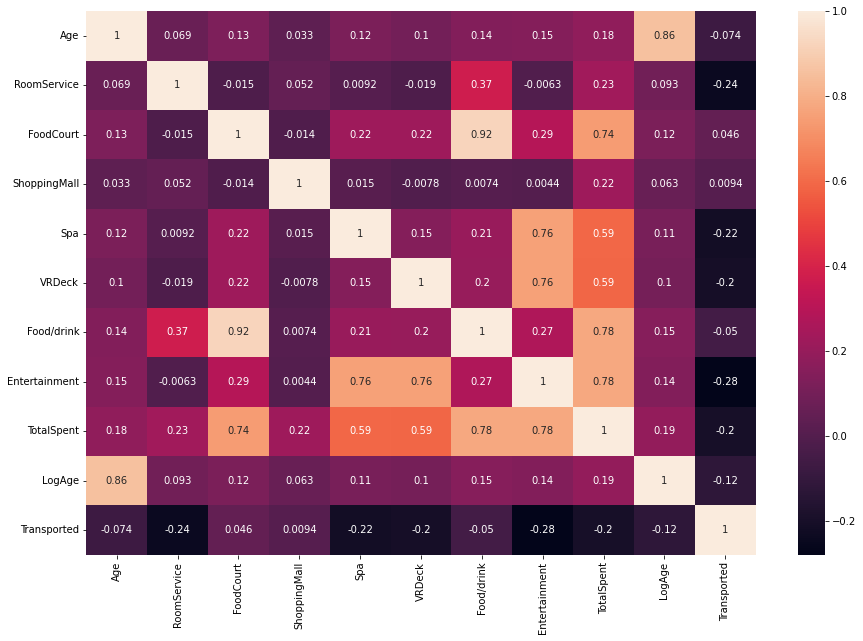

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))

# astype(float) to avoid empty dataframe error
numerical_corrs = train[continuous_cols + ['Transported']].astype(float).corr()
sns.heatmap(numerical_corrs, annot=True, ax=ax)

In [19]:
# sort numerical features from largest to smallest abs correlation
print(numerical_corrs['Transported'].abs().sort_values(ascending=False))

Transported      1.000000
Entertainment    0.279443
RoomService      0.241124
Spa              0.218545
VRDeck           0.204874
TotalSpent       0.199514
LogAge           0.120084
Age              0.074233
Food/drink       0.050369
FoodCourt        0.045583
ShoppingMall     0.009391
Name: Transported, dtype: float64


## Categorical features ##

<AxesSubplot:>

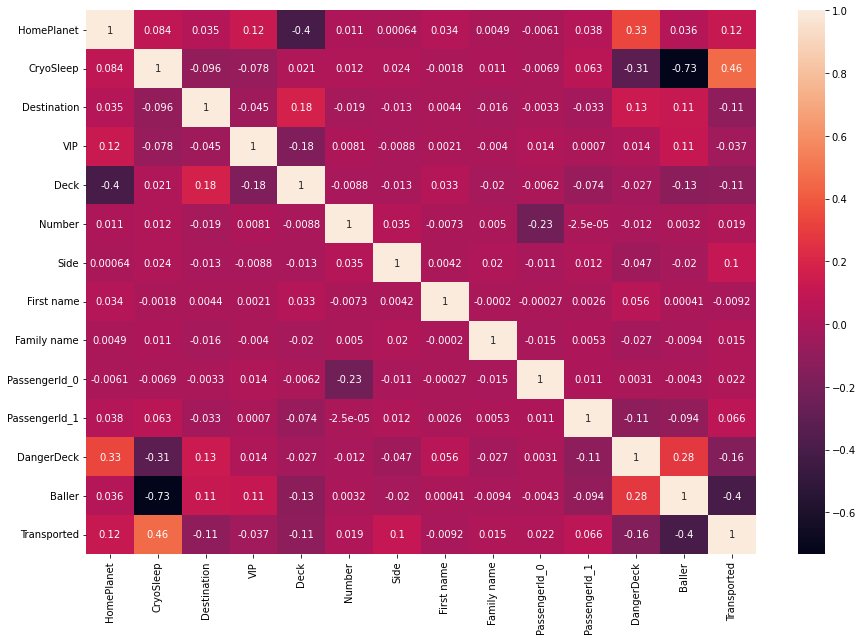

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
categorical_corrs = train[cat_cols + ['Transported']].corr()
sns.heatmap(categorical_corrs, annot=True)

In [21]:
# sort categorical features from largest to smallest abs correlation
print(categorical_corrs['Transported'].abs().sort_values(ascending=False))

Transported      1.000000
CryoSleep        0.460132
Baller           0.403438
DangerDeck       0.158068
HomePlanet       0.115461
Deck             0.113992
Destination      0.108152
Side             0.101397
PassengerId_1    0.066390
VIP              0.037261
PassengerId_0    0.021825
Number           0.019393
Family name      0.014651
First name       0.009164
Name: Transported, dtype: float64


## Dropping redundant features ##
# Sometimes less is more #

It is clear from above that multiple features provide almost no tangible input to the models.

In [22]:
# see total features corrs
total_corrs = pd.concat([numerical_corrs['Transported'], categorical_corrs['Transported']]).abs().sort_values(ascending=False)
print(total_corrs)

Transported      1.000000
Transported      1.000000
CryoSleep        0.460132
Baller           0.403438
Entertainment    0.279443
RoomService      0.241124
Spa              0.218545
VRDeck           0.204874
TotalSpent       0.199514
DangerDeck       0.158068
LogAge           0.120084
HomePlanet       0.115461
Deck             0.113992
Destination      0.108152
Side             0.101397
Age              0.074233
PassengerId_1    0.066390
Food/drink       0.050369
FoodCourt        0.045583
VIP              0.037261
PassengerId_0    0.021825
Number           0.019393
Family name      0.014651
ShoppingMall     0.009391
First name       0.009164
Name: Transported, dtype: float64


In [23]:
# remove the double transported value, and all rows less than 0.1
total_corrs[total_corrs > 0.1][1:]

Transported      1.000000
CryoSleep        0.460132
Baller           0.403438
Entertainment    0.279443
RoomService      0.241124
Spa              0.218545
VRDeck           0.204874
TotalSpent       0.199514
DangerDeck       0.158068
LogAge           0.120084
HomePlanet       0.115461
Deck             0.113992
Destination      0.108152
Side             0.101397
Name: Transported, dtype: float64

In [24]:
train = train[total_corrs[total_corrs > 0.1][1:].keys()]
test = test[total_corrs[total_corrs > 0.1][2:].keys()]

print(f'Training:\n{train.head()}\nTesting:\n{test.head()}')

Training:
   Transported  CryoSleep  Baller  Entertainment  RoomService       Spa  \
0        False          0       0       0.000000     0.000000  0.000000   
1         True          0       1       0.020734     0.007608  0.024500   
2        False          0       1       0.236503     0.003001  0.299670   
3        False          0       1       0.123147     0.000000  0.148563   
4         True          0       1       0.019825     0.021149  0.025214   

     VRDeck  TotalSpent  DangerDeck    LogAge  HomePlanet  Deck  Destination  \
0  0.000000    0.000000           0  0.841820           1     1            2   
1  0.001823    0.020452           1  0.734563           0     5            2   
2  0.002030    0.288521           1  0.930514           1     0            2   
3  0.007997    0.143830           1  0.804733           1     0            2   
4  0.000083    0.030317           1  0.646553           0     5            2   

   Side  
0     0  
1     1  
2     1  
3     1  
4     1 

Split into train into features and target dfs

In [25]:
Y_train = train['Transported']
X_train = train.loc[:, train.columns != 'Transported']

# Models #

In [26]:
from sklearn.neural_network import MLPClassifier

neural_net = MLPClassifier(hidden_layer_sizes=(400, 200, 100, 20), early_stopping=True, validation_fraction=0.2, verbose=True)
neural_net.fit(X_train, Y_train)

Iteration 1, loss = 0.57157479
Validation score: 0.728580
Iteration 2, loss = 0.52757345
Validation score: 0.747556
Iteration 3, loss = 0.50499600
Validation score: 0.752731
Iteration 4, loss = 0.48304586
Validation score: 0.752731
Iteration 5, loss = 0.46480021
Validation score: 0.759057
Iteration 6, loss = 0.45363477
Validation score: 0.766532
Iteration 7, loss = 0.44230481
Validation score: 0.786084
Iteration 8, loss = 0.44228907
Validation score: 0.788384
Iteration 9, loss = 0.43055527
Validation score: 0.761932
Iteration 10, loss = 0.43827317
Validation score: 0.778608
Iteration 11, loss = 0.42209566
Validation score: 0.795285
Iteration 12, loss = 0.41084424
Validation score: 0.791834
Iteration 13, loss = 0.42061815
Validation score: 0.794135
Iteration 14, loss = 0.40726666
Validation score: 0.789534
Iteration 15, loss = 0.40776676
Validation score: 0.803335
Iteration 16, loss = 0.40941302
Validation score: 0.795285
Iteration 17, loss = 0.40576393
Validation score: 0.782059
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(400, 200, 100, 20),
              validation_fraction=0.2, verbose=True)

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_params = {'n_neighbors': [3, 5, 7]}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=4, refit=True, verbose=1, return_train_score=True)
knn.fit(X_train, Y_train)
print(knn.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7599226040917395


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    6.3s finished


In [28]:
from sklearn.svm import SVC

#svc_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
#svc = GridSearchCV(SVC(), svc_params, n_jobs=4, verbose=2)
svc = SVC(kernel='rbf').fit(X_train, Y_train)

In [29]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = GaussianProcessClassifier().fit(X_train, Y_train)

In [30]:
from sklearn.tree import DecisionTreeClassifier

dtc_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,10)}
clf_dtc = GridSearchCV(DecisionTreeClassifier(), dtc_params, n_jobs=4, verbose=1)
clf_dtc.fit(X_train, Y_train)
dtc = clf_dtc.best_estimator_
print(f'{clf_dtc.best_score_}\n{clf_dtc.best_estimator_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7928237396861152
DecisionTreeClassifier(max_depth=7)


[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.9s finished


In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada_params = {'n_estimators': [100, 300, 500]}
clf = GridSearchCV(AdaBoostClassifier(base_estimator=clf_dtc.best_estimator_), ada_params, n_jobs=4, verbose=1)
clf.fit(X_train, Y_train)
ada = clf.best_estimator_
print(f'{clf.best_score_}\n{clf.best_estimator_}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   30.8s finished


0.7771764125117209
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                   n_estimators=500)


In [32]:
from sklearn.ensemble import RandomForestClassifier

rfc_params = {'n_estimators': [100, 300, 500]}
clf = GridSearchCV(RandomForestClassifier(), rfc_params, n_jobs=4, verbose=1)
clf.fit(X_train, Y_train)
rfc = clf.best_estimator_
print(f'{clf.best_score_}\n{clf.best_estimator_}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   16.7s finished


0.7909823443892929
RandomForestClassifier(n_estimators=500)


In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_params = {'loss': ['deviance', 'exponential'],
              'n_estimators': list(range(100, 301, 100)),
              'max_depth': [1, 3, 5]}
clf = GridSearchCV(GradientBoostingClassifier(), gbc_params, n_jobs=4, verbose=1)
clf.fit(X_train, Y_train)
gbc = clf.best_estimator_
print(f'{clf.best_score_}\n{clf.best_estimator_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.6s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.1min finished


0.8023720363607248
GradientBoostingClassifier(loss='exponential', max_depth=5, n_estimators=200)


In [34]:
def create_submission(model):
    submission['Transported'] = model.predict(test)
    submission.to_csv("/kaggle/working/submission.csv", index=False)
    
create_submission(neural_net)